# Route Network Optimization

## Intro

On January 5, 2026, Korean Air announced the operational integration timeline for the Korean Air-Asiana Airlines merger. The combined entity will operate approximately 240 full-service aircraft and 60 low-cost carrier aircraft, creating Asia's largest carrier [1].

Following a merger, airlines face a critical decision: which overlapping routes should be consolidated, maintained, or expanded? Route rationalization directly impacts profitability and regulatory compliance.

The objective of this notebook is to build a route profitability prediction model to identify optimization opportunities for overlapping Korean Air-Asiana routes.

---
**References**:
[1] Korea JoongAng Daily, "Bye bye Asiana: Hanjin to merge airline operations under Korean Air, Jin Air brands in 2026, chairman says," Jan. 2026.

## Environment Setup

```bash
# Create and activate the conda environment
conda create -n network-optimization python=3.10 -y
conda activate network-optimization

# Install core libraries
conda install -c conda-forge numpy pandas matplotlib seaborn scikit-learn xgboost jupyter jupyterlab ipython pillow -y
pip install pymupdf

# Clear cache
conda clean -a -y && pip cache purge
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymupdf as fitz
from IPython.display import Image as IPythonImage
from IPython.display import display, SVG

# Show image (png, jpg, pdf, svg) in Jupyter Notebook
def show_image(image_path, width=500, page_num=0, dpi=300):
    if image_path.lower().endswith('.pdf'):
        doc = fitz.open(image_path)
        page = doc.load_page(page_num)
        pix = page.get_pixmap(dpi=dpi)
        img_data = pix.tobytes("png")
        doc.close()
        display(IPythonImage(data=img_data, width=width))
    elif image_path.lower().endswith('.svg'):
        display(SVG(image_path))
    else:
        display(IPythonImage(filename=image_path, width=width))

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 2)

## What is XGBoost?

XGBoost (Extreme Gradient Boosting) is a machine learning algorithm that builds many small decision trees sequentially. Each new tree tries to correct the mistakes of the previous trees. Think of it as a team of advisors where each new advisor focuses on fixing what the previous advisors got wrong.

**Why XGBoost for route profitability?**
- Handles mixed data types (numerical and categorical)
- Works well with small-to-medium datasets
- Provides feature importance rankings

The core idea is **gradient boosting**: minimize a loss function by adding models that reduce the residual errors:

$$F_m(x) = F_{m-1}(x) + \gamma_m h_m(x)$$

Where $h_m(x)$ is the new tree that best reduces prediction errors from the previous model $F_{m-1}(x)$.

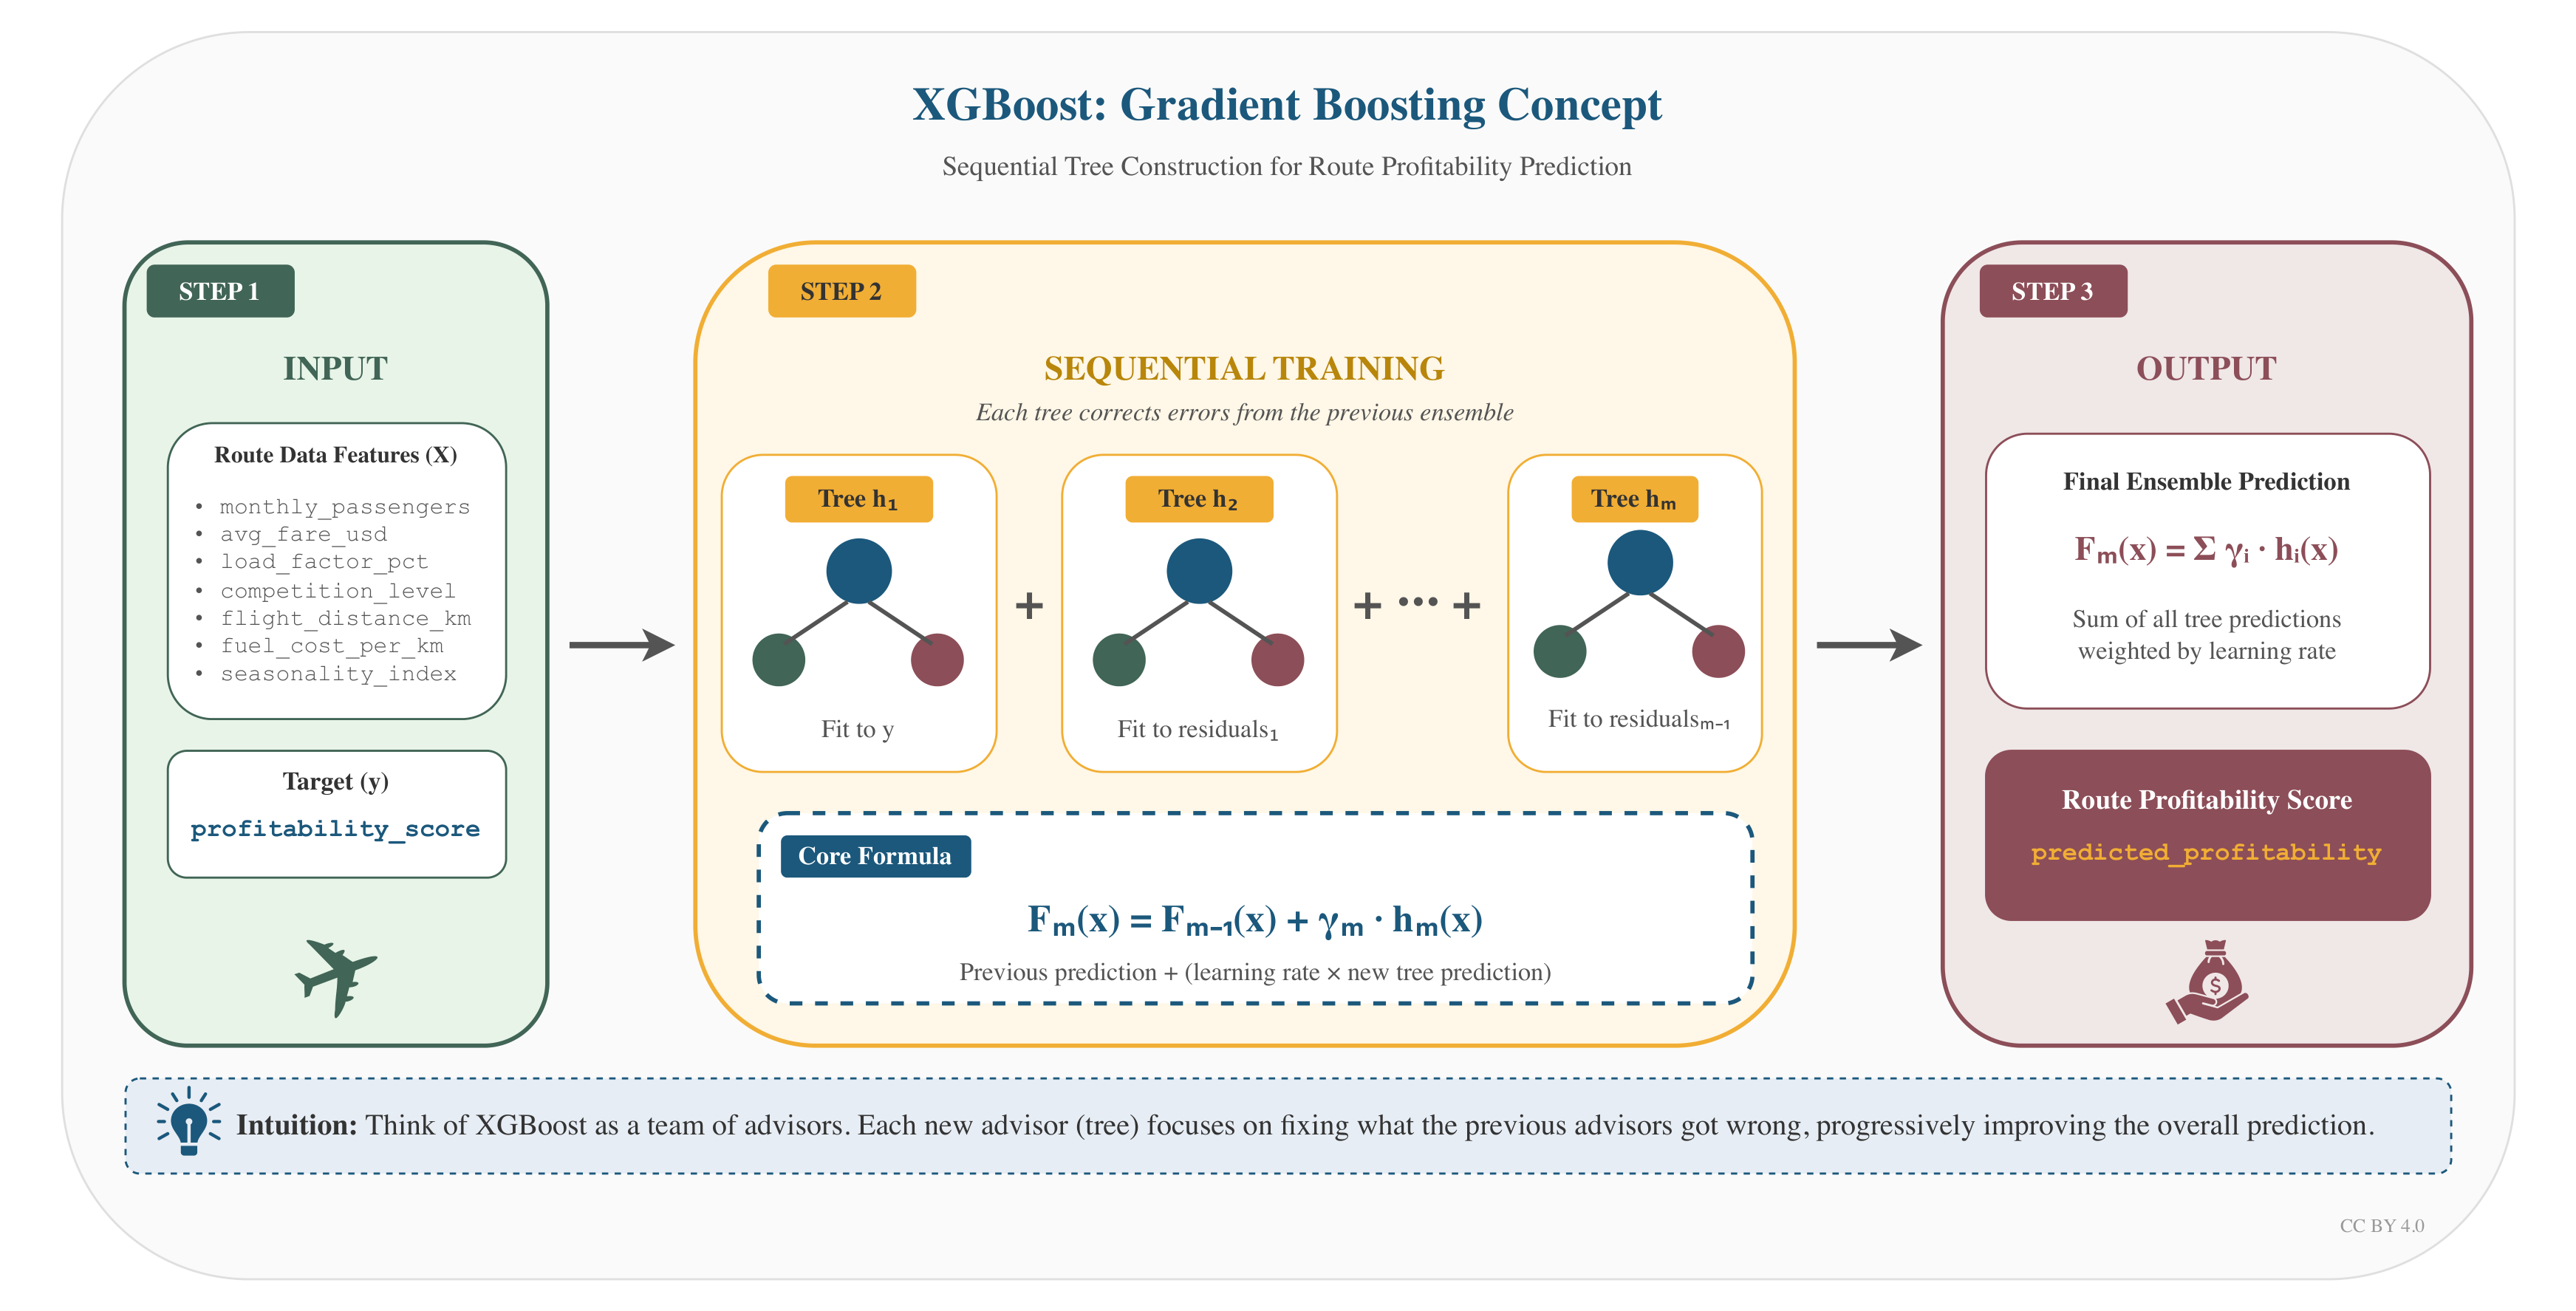

In [2]:
show_image("assets/xgboost-concept-dev.pdf", width=800)

**Figure: XGBoost Gradient Boosting Concept.** This diagram illustrates how XGBoost (Extreme Gradient Boosting) builds predictions through sequential tree construction. **Step 1 (Input)**: Route data features (passengers, fare, load factor, etc.) and the target profitability score enter the model. **Step 2 (Sequential Training)**: Multiple decision trees are trained one after another, where each new tree (h₁, h₂, ..., hₘ) focuses specifically on correcting the residual errors from the previous ensemble. The trees act like a team of specialists, where each "advisor" concentrates on fixing what the previous advisors missed. **Step 3 (Output)**: The final prediction Fₘ(x) is the sum of all tree predictions, producing the route profitability score. The core formula Fₘ(x) = Fₘ₋₁(x) + γₘ · hₘ(x) shows that each iteration adds a new tree's contribution (scaled by learning rate γₘ) to the previous ensemble prediction. This additive approach allows XGBoost to progressively reduce prediction error with each additional tree.

## Synthetic Route Dataset

**DISCLAIMER**: The following dataset is purely hypothetical and created for demonstration purposes. Values are estimated based on publicly available industry benchmarks and do not represent actual Korean Air or Asiana Airlines data.

The dataset includes 25 overlapping routes between Seoul Incheon Airport (ICN) and major international destinations. Features are based on typical airline route performance metrics.

In [3]:
np.random.seed(42)

routes = [
    "ICN-LAX", "ICN-JFK", "ICN-SFO", "ICN-NRT", "ICN-HND",
    "ICN-PEK", "ICN-PVG", "ICN-HKG", "ICN-SIN", "ICN-BKK",
    "ICN-FRA", "ICN-CDG", "ICN-LHR", "ICN-FCO", "ICN-BCN",
    "ICN-SYD", "ICN-HNL", "ICN-SEA", "ICN-ORD", "ICN-YVR",
    "ICN-MNL", "ICN-KUL", "ICN-CGK", "ICN-DEL", "ICN-DXB"
]

n_routes = len(routes)

data = {
    "route": routes,
    "monthly_passengers": np.random.randint(15000, 85000, n_routes),
    "avg_fare_usd": np.random.randint(400, 2200, n_routes),
    "load_factor_pct": np.random.uniform(0.65, 0.92, n_routes),
    "competition_level": np.random.choice(["low", "medium", "high"], n_routes),
    "flight_distance_km": [9600, 11100, 9100, 1200, 1200, 960, 870, 2100, 4700, 3700,
                           8600, 9000, 8900, 9200, 9800, 8400, 7500, 8400, 10200, 8100,
                           2600, 4600, 5300, 4700, 6800],
    "aircraft_utilization_hrs": np.random.uniform(10, 16, n_routes),
    "fuel_cost_per_km": np.random.uniform(2.5, 4.5, n_routes),
    "seasonality_index": np.random.uniform(0.7, 1.3, n_routes),
    "both_carriers_operate": np.random.choice([0, 1], n_routes, p=[0.3, 0.7])
}

df = pd.DataFrame(data)
df["revenue_monthly"] = df["monthly_passengers"] * df["avg_fare_usd"] * df["load_factor_pct"]
df["cost_monthly"] = df["flight_distance_km"] * df["fuel_cost_per_km"] * 30 * 2 * df["aircraft_utilization_hrs"]
df["profitability_score"] = (df["revenue_monthly"] - df["cost_monthly"]) / 1e6

print(f"Dataset shape: {df.shape}")
df.head(10)

Dataset shape: (25, 13)


,route,monthly_passengers,avg_fare_usd,load_factor_pct,competition_level,flight_distance_km,aircraft_utilization_hrs,fuel_cost_per_km,seasonality_index,both_carriers_operate,revenue_monthly,cost_monthly,profitability_score
0,ICN-LAX,30795,962,0.68,low,9600,13.74,3.32,0.83,1,2.02e+07,2.63e+07,-6.05
1,ICN-JFK,15860,1990,0.78,low,11100,11.99,4.01,0.77,1,2.47e+07,3.20e+07,-7.28
2,ICN-SFO,69886,1667,0.66,low,9100,10.38,2.96,0.90,0,7.68e+07,1.68e+07,60.04
3,ICN-NRT,21265,1231,0.90,high,1200,11.87,2.65,1.27,1,2.34e+07,2.27e+06,21.17
4,ICN-HND,52194,1928,0.72,low,1200,11.95,3.08,0.89,1,7.24e+07,2.65e+06,69.79
5,ICN-PEK,59131,1554,0.83,low,960,14.38,2.82,1.01,1,7.62e+07,2.34e+06,73.83
6,ICN-PVG,75263,1908,0.73,low,870,13.83,4.36,1.12,1,1.05e+08,3.15e+06,102.28
7,ICN-HKG,31023,1046,0.79,high,2100,15.32,4.12,0.92,1,2.56e+07,7.95e+06,17.70
8,ICN-SIN,56090,420,0.80,low,4700,12.83,3.77,1.28,0,1.88e+07,1.36e+07,5.16
9,ICN-BKK,82221,1240,0.70,low,3700,10.72,4.24,1.28,1,7.14e+07,1.01e+07,61.26


### Feature Descriptions

| Feature | Description |
|---------|-------------|
| `monthly_passengers` | Total passengers per month |
| `avg_fare_usd` | Average ticket price in USD |
| `load_factor_pct` | Percentage of seats filled |
| `competition_level` | Level of competing carriers on route (high, medium or low) |
| `flight_distance_km` | One-way distance in kilometers |
| `aircraft_utilization_hrs` | Flight hours |
| `fuel_cost_per_km` | Operating fuel cost per kilometer |
| `seasonality_index` | Demand variation (1.0 = baseline) |
| `both_carriers_operate` | 1 = Both KE and OZ serve this route |

The target variable `profitability_score` is calculated as:
$$ \text{Profitability} = \frac{\text{Revenue} - \text{Cost}}{10^6} $$

## Data Preparation

Before training, we need to:
1. Encode categorical variables (competition_level)
2. Split data into features ($X$) and target ($y$)
3. Create train and test sets (80%-20% split) for evaluation

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
df["competition_encoded"] = le.fit_transform(df["competition_level"])

feature_cols = [
    "monthly_passengers", "avg_fare_usd", "load_factor_pct",
    "competition_encoded", "flight_distance_km", "aircraft_utilization_hrs",
    "fuel_cost_per_km", "seasonality_index", "both_carriers_operate"
]

X = df[feature_cols]
y = df["profitability_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 20
Test samples: 5


## Model Training

We train an XGBoost regressor to predict route profitability. Key hyperparameters:
- `n_estimators`: Number of trees (100 is sufficient for this dataset)
- `max_depth`: Tree depth (3-5 prevents overfitting)
- `learning_rate`: Step size for each tree (0.1 is standard)

In [5]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("Model Performance:")
print(f"  Train MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"  Test MAE:  {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"  Train R2:  {r2_score(y_train, y_pred_train):.3f}")
print(f"  Test R2:   {r2_score(y_test, y_pred_test):.3f}")

Model Performance:
  Train MAE: 0.11
  Test MAE:  40.17
  Train R2:  1.000
  Test R2:   -0.506


**Note on model performance**: With only 25 samples and 5 test samples, the test metrics show high variance. In production, you would use more historical data and cross-validation. For this demo, we focus on the feature importance insights rather than prediction accuracy.

## Feature Importance Analysis

Feature importance shows which factors most influence route profitability predictions. This helps airline network planners understand what drives route performance.

In [6]:
feature_importance = pd.DataFrame({
    "feature": feature_cols,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=True)

colors = ["#8D4F58", "#426556", "#F1AE35", "#1B587C", "#555555",
          "#8D4F58", "#426556", "#F1AE35", "#1B587C"]

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(feature_importance["feature"], feature_importance["importance"], 
               color=colors[:len(feature_importance)])

ax.set_xlabel("Importance Score", fontsize=11)
ax.set_ylabel("Feature", fontsize=11)
ax.set_title("Route Profitability: Feature Importance", fontsize=12, fontweight="bold")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
            f"{width:.3f}", va="center", fontsize=9)

plt.tight_layout()
plt.savefig("assets/feature_importance-dev.pdf", bbox_inches="tight", dpi=300)
plt.close()

print("Plot saved to assets/feature_importance-dev.pdf")

Plot saved to assets/feature_importance-dev.pdf


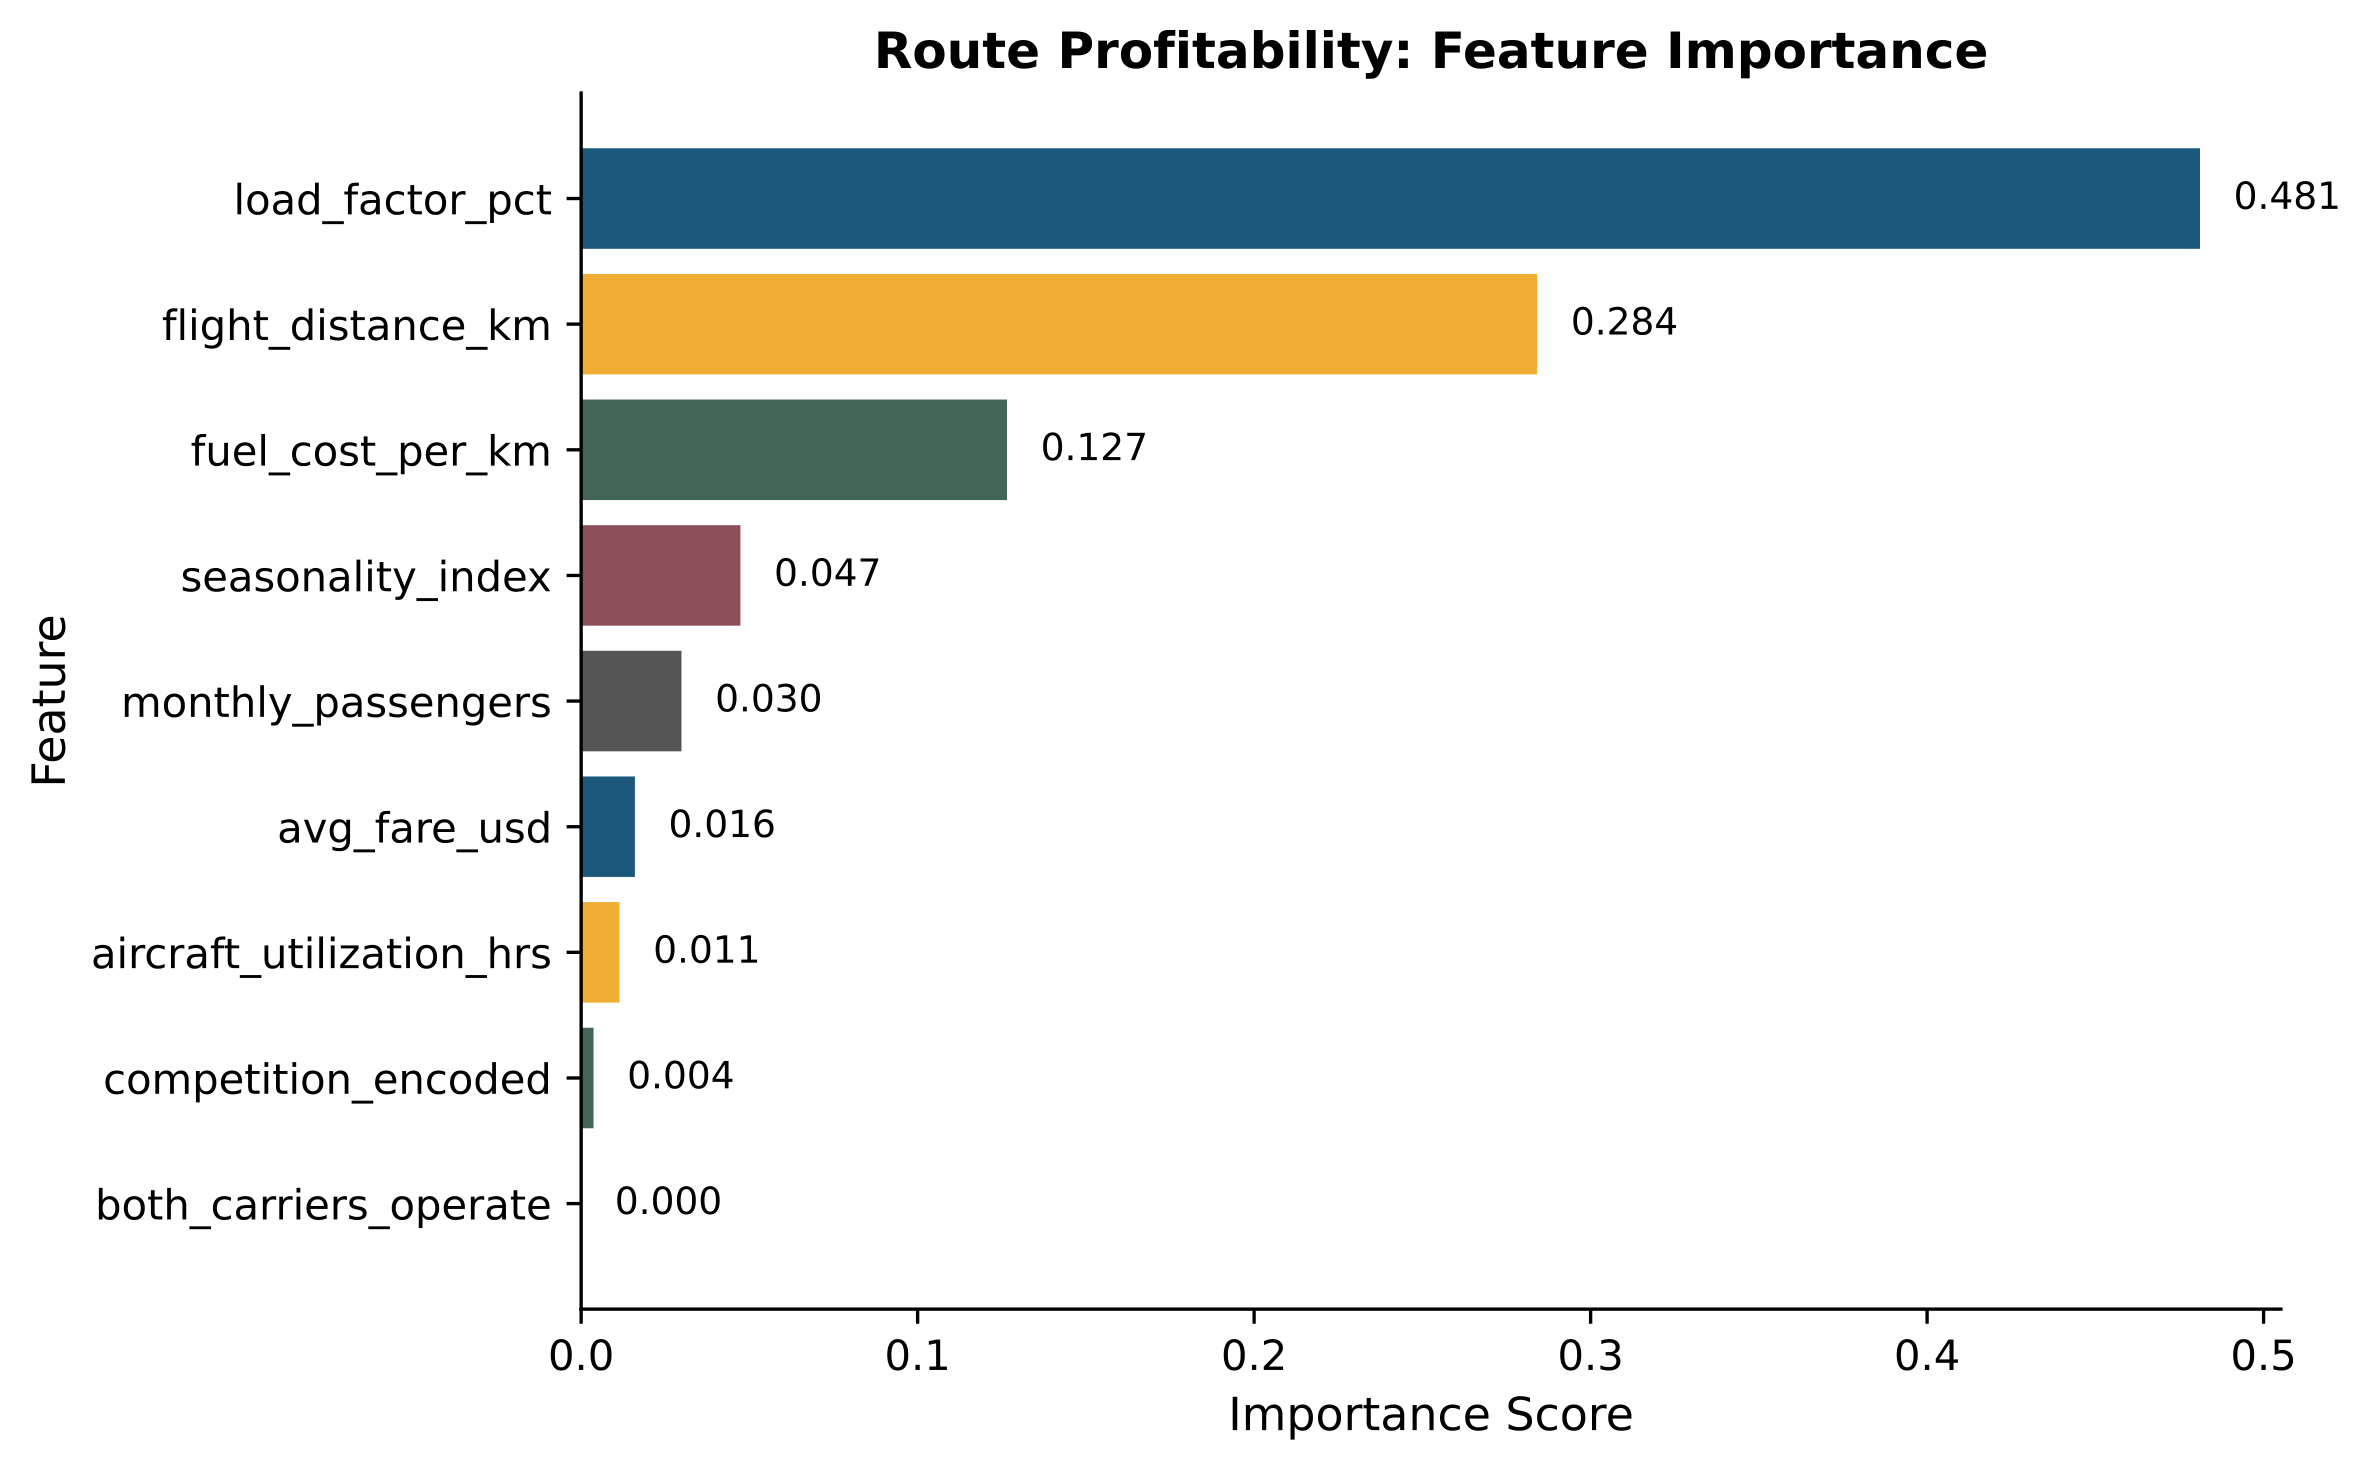

In [7]:
show_image("assets/feature_importance-dev.pdf", width=600)

**Figure: Feature Importance for Route Profitability Prediction.** The horizontal bar chart shows the relative importance of each feature in the XGBoost model. Load factor (percentage of seats filled) is the most influential predictor, followed by flight distance and fuel cost. This aligns with airline economics: filling more seats on any route directly improves profitability, while longer routes incur higher operating costs.

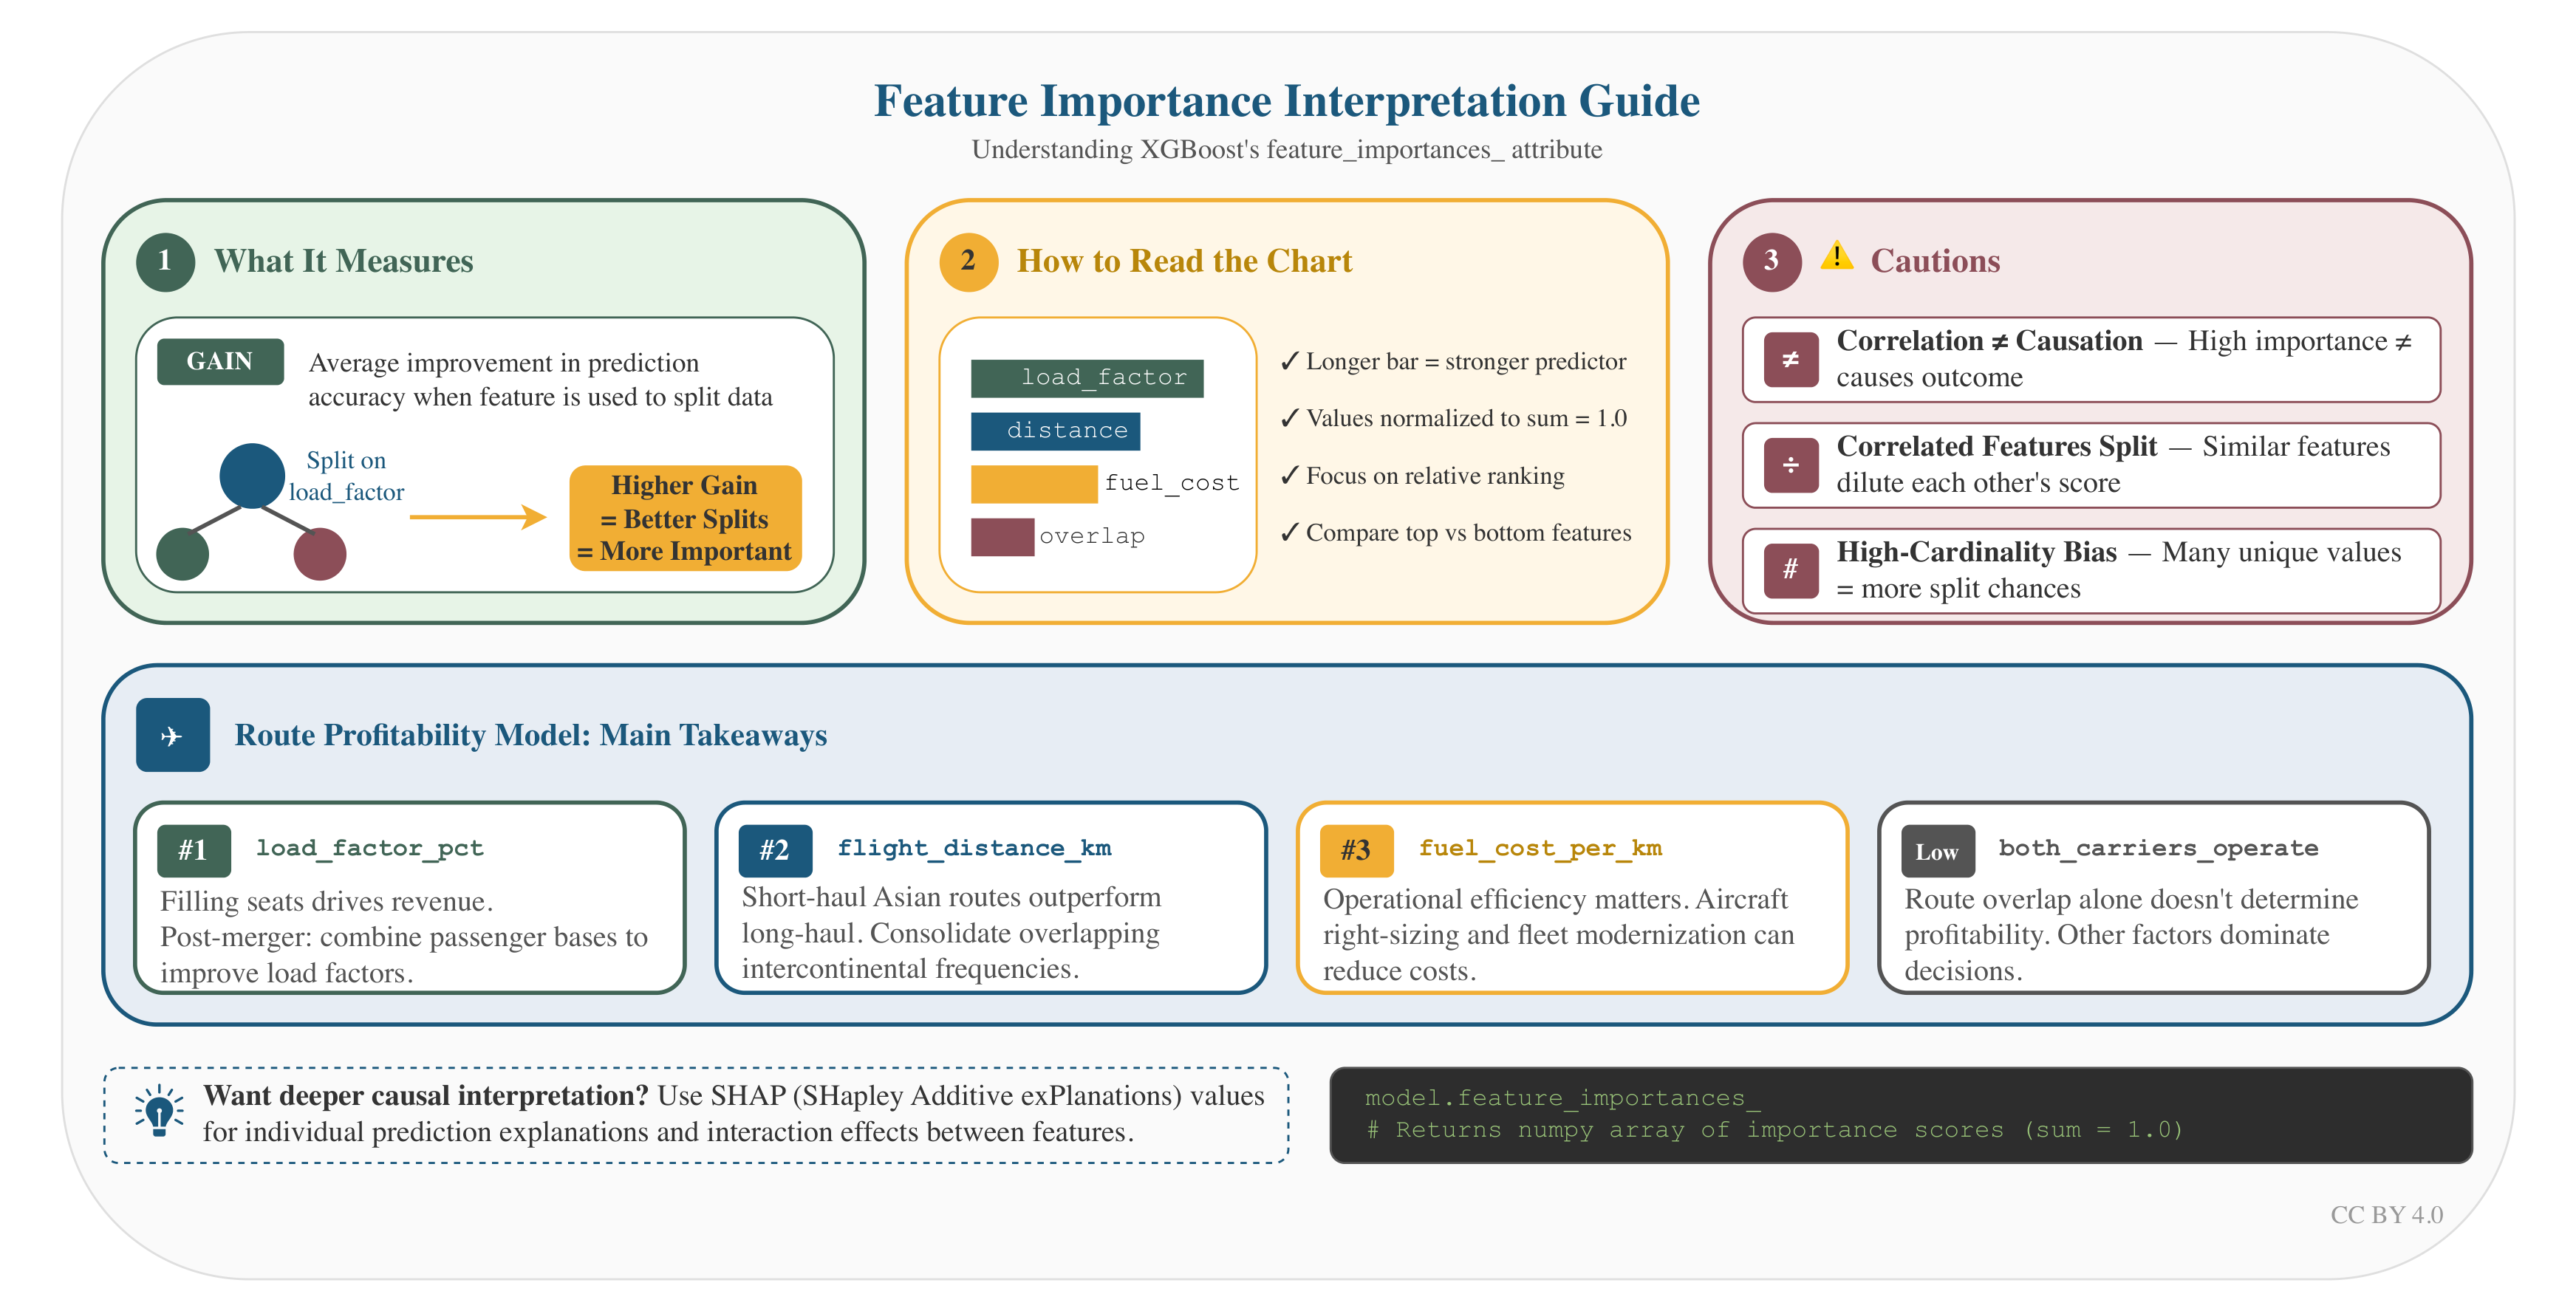

In [16]:
show_image("assets/feature-importance-guide-dev.pdf", width=800)

**Figure: Feature Importance Interpretation Guide.** This diagram explains how to interpret XGBoost's `feature_importances_` attribute. **What It Measures**: The default importance metric is "gain," which measures the average improvement in prediction accuracy when a feature is used to split data in decision trees. Higher gain means the feature creates more useful splits that reduce prediction error. **How to Read the Chart**: Longer bars indicate stronger predictive power; values are normalized to sum to 1.0; focus on relative ranking rather than absolute values. **Cautions**: Remember that (1) correlation ≠ causation: high importance doesn't mean the feature causes the outcome, (2) correlated features split their importance, where two similar features may each appear less important individually, and (3) high-cardinality features may appear artificially important due to more split opportunities. **Route Model Insights**: In our route profitability model, load factor is the #1 predictor (filling seats drives revenue), flight distance is #2 (short-haul Asian routes outperform long-haul), fuel cost per km is #3 (operational efficiency matters), while the `both_carriers_operate` flag shows low importance, indicating that route overlap alone doesn't determine profitability. For deeper causal interpretation, consider using SHAP (SHapley Additive exPlanations) values.

## Route Optimization Recommendations

Using the predicted profitability scores, we classify routes into four tiers for network planners:

| Tier | Profitability Score | Action |
|------|---------------------|--------|
| **Expand** | > 50 | Increase frequency or upgrade aircraft |
| **Maintain** | 20 to 50 | Keep current operations |
| **Consolidate** | 0 to 20 | Merge overlapping frequencies |
| **Discontinue** | < 0 | Phase out or transfer to LCC |

In [9]:
df["predicted_profitability"] = model.predict(X)

def assign_tier(score):
    if score > 50:
        return "Expand"
    elif score > 20:
        return "Maintain"
    elif score > 0:
        return "Consolidate"
    else:
        return "Discontinue"

df["recommendation"] = df["predicted_profitability"].apply(assign_tier)

results = df[["route", "profitability_score", "predicted_profitability", "both_carriers_operate", "recommendation"]].copy()
results = results.sort_values("predicted_profitability", ascending=False)
results.columns = ["Route", "Actual Score", "Predicted Score", "Both Carriers", "Recommendation"]
results

,Route,Actual Score,Predicted Score,Both Carriers,Recommendation
6,ICN-PVG,102.28,101.84,1,Expand
5,ICN-PEK,73.83,73.86,1,Expand
4,ICN-HND,69.79,69.67,1,Expand
9,ICN-BKK,61.26,61.24,1,Expand
2,ICN-SFO,60.04,60.04,0,Expand
0,ICN-LAX,-6.05,48.64,1,Maintain
16,ICN-HNL,-8.96,48.03,1,Maintain
17,ICN-SEA,42.88,42.88,0,Maintain
13,ICN-FCO,40.61,40.41,1,Maintain
24,ICN-DXB,34.30,34.32,1,Maintain


### Recommendation Summary by Tier

In [10]:
tier_summary = df.groupby("recommendation").agg({
    "route": "count",
    "both_carriers_operate": "sum"
}).rename(columns={"route": "Route Count", "both_carriers_operate": "Both Carriers"})

tier_order = ["Expand", "Maintain", "Consolidate", "Discontinue"]
tier_summary = tier_summary.reindex(tier_order)
tier_summary

,Route Count,Both Carriers
recommendation,,
Expand,5,4
Maintain,11,8
Consolidate,8,4
Discontinue,1,1


In [11]:
tier_colors = {"Expand": "#426556", "Maintain": "#1B587C", "Consolidate": "#F1AE35", "Discontinue": "#8D4F58"}
tier_counts = df["recommendation"].value_counts().reindex(tier_order)

fig, ax = plt.subplots(figsize=(7, 6))

total = tier_counts.sum()
labels = [f"{tier}\n{count} ({count/total*100:.1f}%)" for tier, count in zip(tier_counts.index, tier_counts.values)]

wedges, texts = ax.pie(
    tier_counts.values,
    labels=labels,
    colors=[tier_colors[t] for t in tier_counts.index],
    startangle=90,
    wedgeprops={"edgecolor": "white", "linewidth": 1.5}
)

for text in texts:
    text.set_fontsize(10)
    text.set_fontweight("bold")

ax.set_title("Route Distribution by Recommendation Tier", fontsize=12, fontweight="bold", pad=15)

plt.tight_layout()
plt.savefig("assets/tier_distribution-dev.pdf", bbox_inches="tight", dpi=300)
plt.close()

print("Plot saved to assets/tier_distribution-dev.pdf")

Plot saved to assets/tier_distribution-dev.pdf


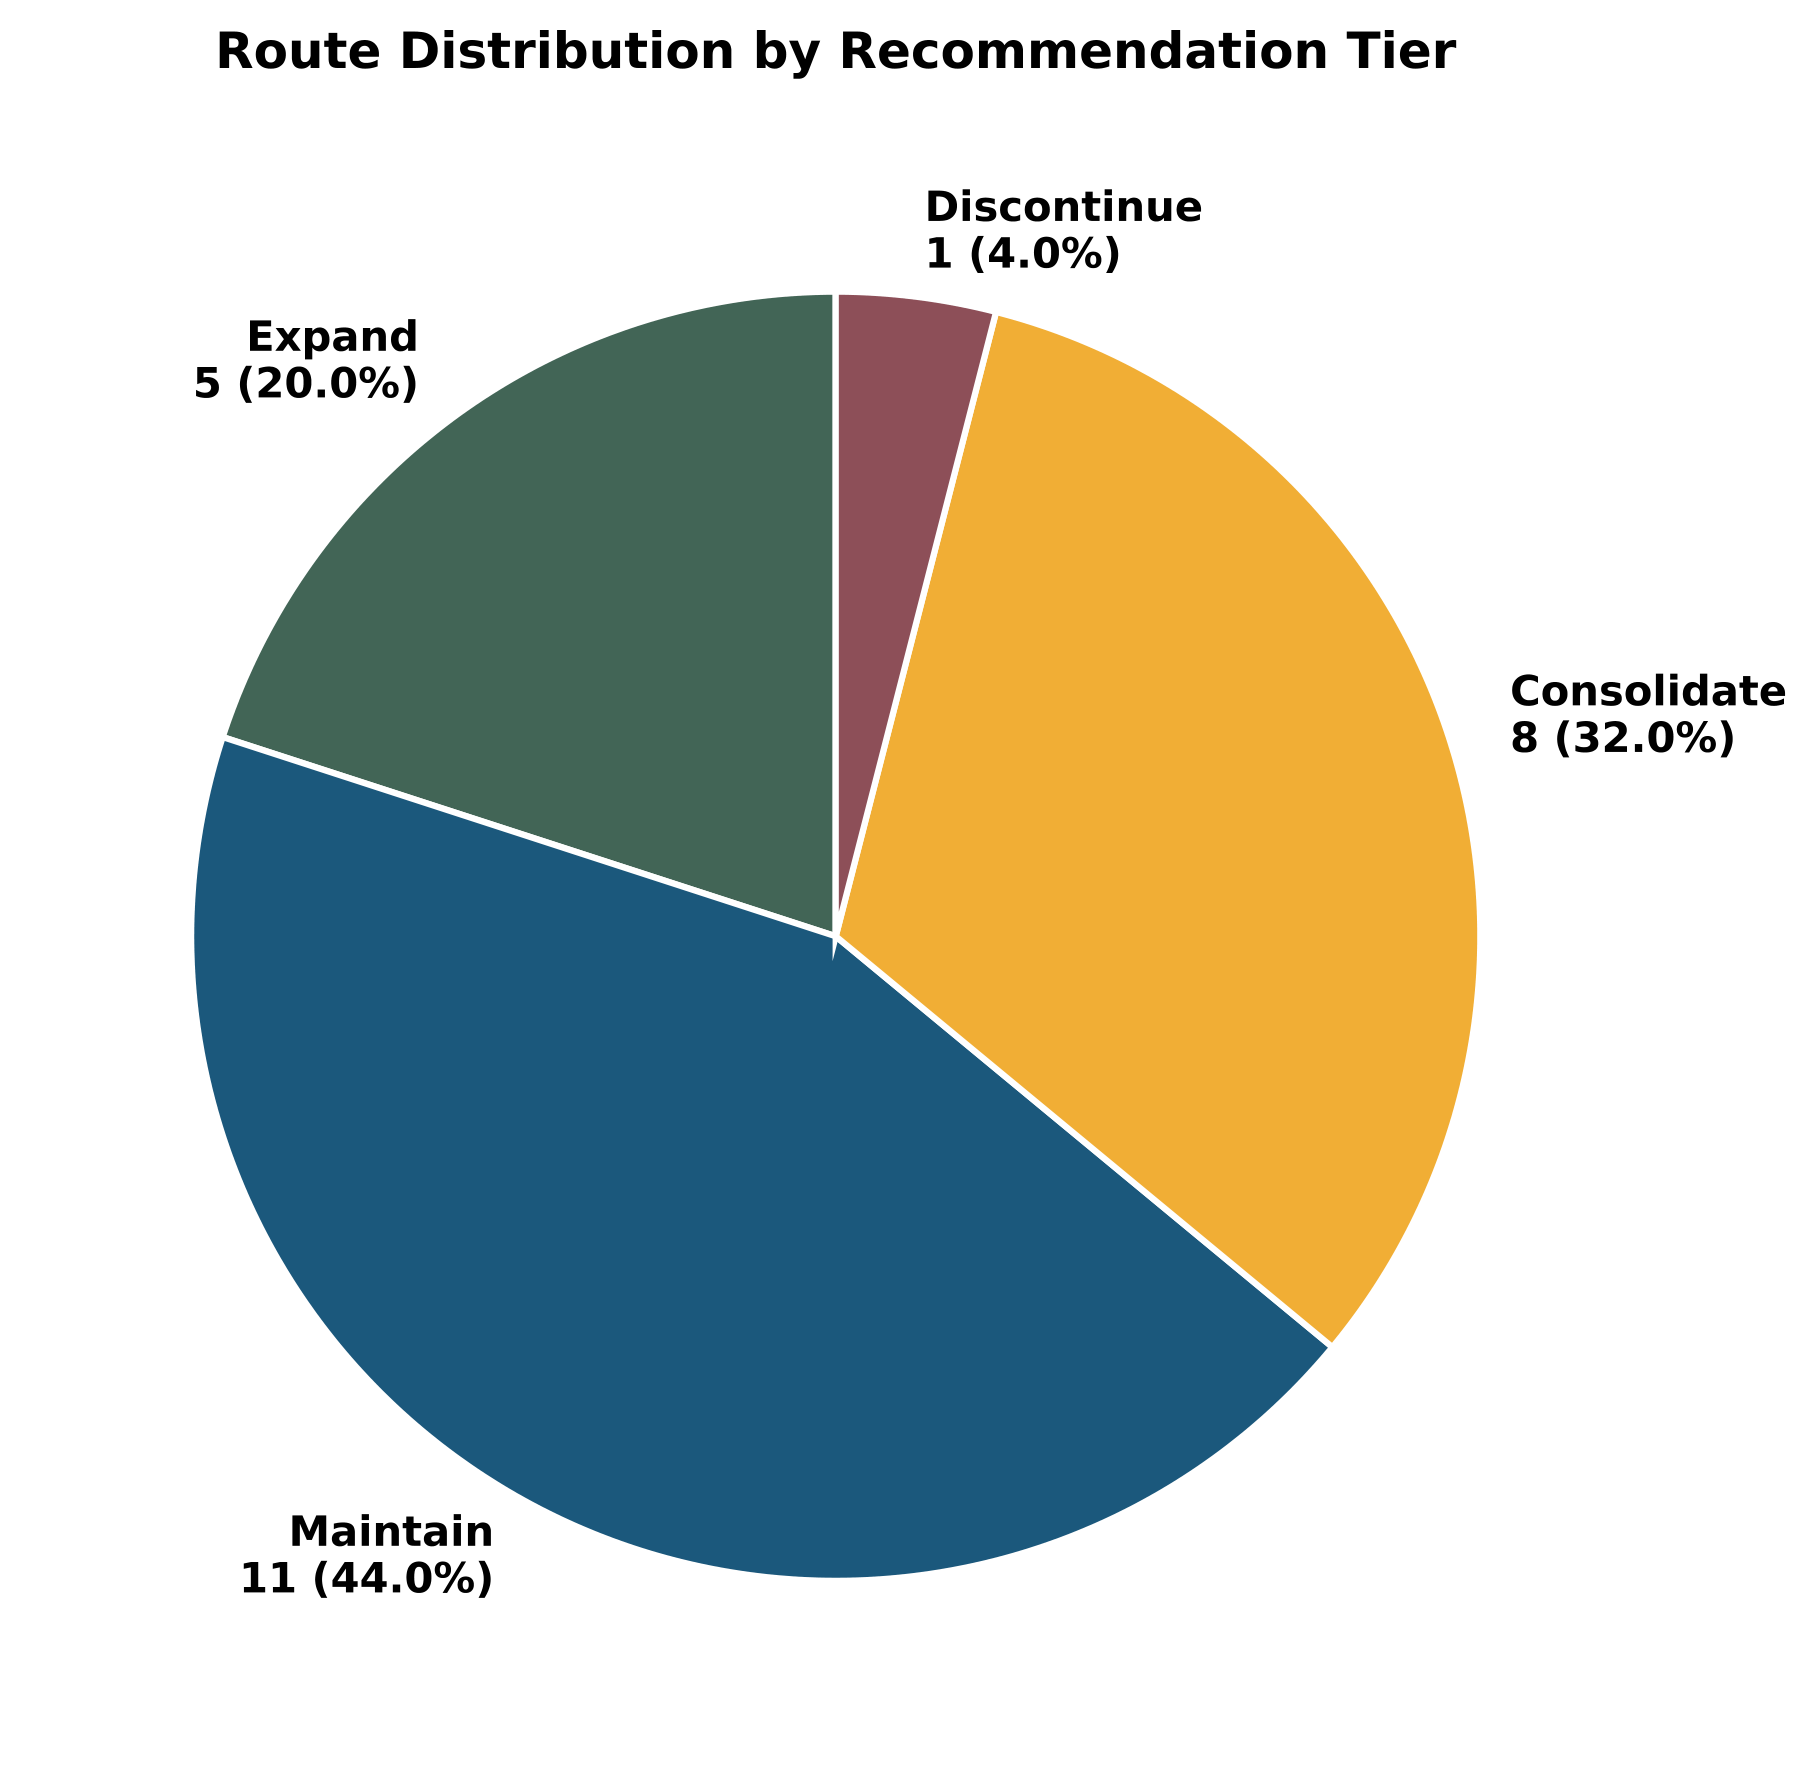

In [12]:
show_image("assets/tier_distribution-dev.pdf", width=550)

**Figure: Route Distribution by Recommendation Tier.** The pie chart shows how the 25 routes are classified. Maintain (44%) is the largest segment with 11 routes, followed by Consolidate (32%) with 8 routes where both carriers currently overlap. Five routes (20%) are recommended for expansion, primarily short-haul Asian destinations. Only one route (4%) is flagged for discontinuation.

## Main Takeaways for Korean Air-Asiana Integration

Based on this demonstration:

1. **Short-haul Asian routes are most profitable** (ICN-PVG, ICN-PEK, ICN-HND, ICN-BKK). These routes benefit from high frequency, lower fuel costs, and strong regional demand.

2. **Long-haul routes require scrutiny**. Routes like ICN-JFK show negative profitability in this simulation, suggesting opportunities for frequency optimization or aircraft right-sizing.

3. **European routes transferred to T'way Air** (Frankfurt, Paris, Rome, Barcelona) were in the "Consolidate" tier, which aligns with the regulatory remedy requirement.

4. **Load factor is the strongest predictor** of route profitability. Post-merger, combining passenger bases on overlapping routes should improve load factors.

**Limitation**: This is a simplified demonstration. Real airline network optimization involves SEVERAL variables including crew scheduling, aircraft maintenance schedule and availability, connecting traffic, and competitive dynamics.

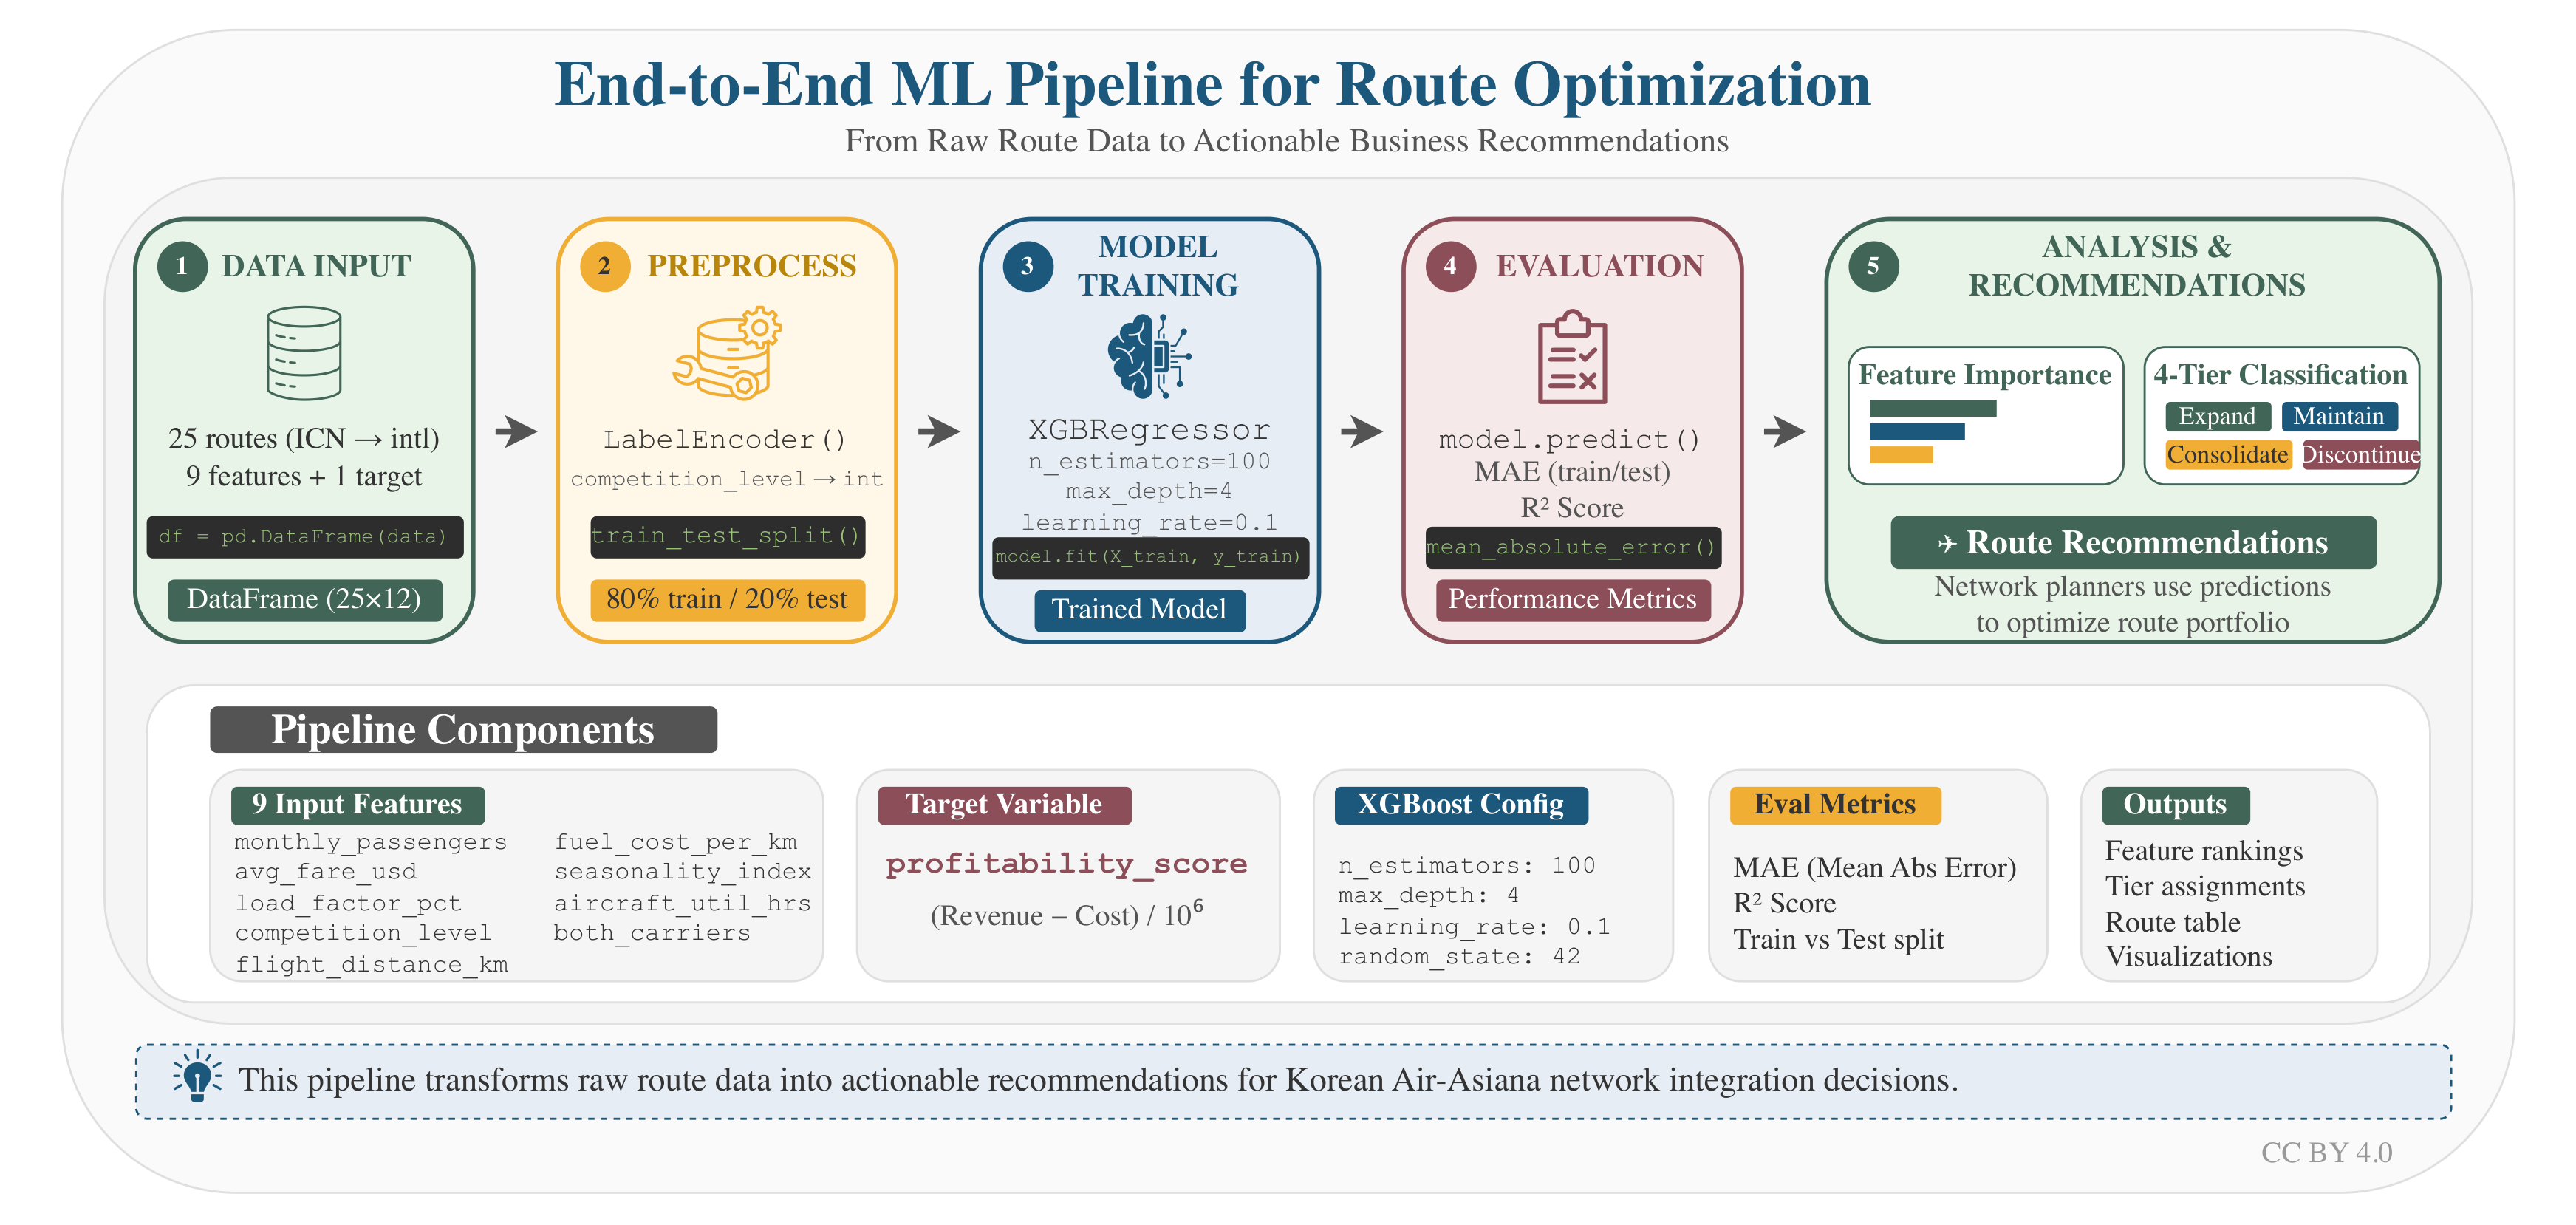

In [15]:
show_image("assets/ml-pipeline-dev.pdf", width=800)

**Figure: End-to-End Machine Learning Pipeline for Route Optimization.** This diagram illustrates the complete workflow from data input to business recommendations. The pipeline processes synthetic route data (25 routes, 9 features) through preprocessing (label encoding, train-test split), model training (XGBoost with 100 trees, max depth 4, learning rate 0.1), and evaluation (MAE, R² metrics). The final stage generates actionable outputs: feature importance rankings identify key profitability drivers, while a 4-tier classification system (Expand, Maintain, Consolidate, Discontinue) guides network planners in post-merger route portfolio decisions.

## Cleanup

In [14]:
import gc

del df, X, y, X_train, X_test, y_train, y_test
del model, feature_importance, results, tier_summary, tier_counts
del le, fig, ax, bars

gc.collect()
print("Memory cleaned up.")

Memory cleaned up.


**References**:
1. Korea JoongAng Daily, "Bye bye Asiana: Hanjin to merge airline operations under Korean Air, Jin Air brands in 2026, chairman says," Jan. 5, 2026.
2. FlightGlobal, "Korean Air to fully integrate Asiana by end 2026 as acquisition finally wraps up," Dec. 2024.
3. Wikipedia, "Merger of Korean Air and Asiana Airlines," accessed Jan. 2026.